# Element Parameter Detection

## Setup

In [1]:
import numpy as np
import math
import random
import os
import os.path
import torch
import sys
import copy
import pickle
import importlib
import torch.nn as nn
import time
import functorch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from chamferdist import ChamferDistance
from pathlib import Path

import ifcopenshell
import open3d as o3d

from src.elements import *
from src.ifc import *
from src. preparation import *
from src.dataset import *
from src.pointnet import *
from src.visualisation import *
from src.geometry import sq_distance
from src.icp import icp_finetuning
from src.chamfer import *
from src.utils import *
from src.plots import plot_error_graph, plot_parameter_errors
from src.pca import testset_PCA
from src.finetune import chamfer_fine_tune
from tqdm.notebook import tqdm


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
random.seed = 42

In [3]:
#path = Path("ModelNet10")
#path = Path('/content/drive/MyDrive/ElementNet/')
path = Path('output/')
#savepath = '/content/drive/MyDrive/ElementNet/'
savepath = 'models/'

## Model

## Test

Analyze results statistically

POINTNET++

In [4]:
train_transforms = transforms.Compose([
                    Normalize(),
#                    RandomNoise(),
                    ToTensor()
                    ])

In [44]:
# load data and model
BASE_DIR = os.path.dirname(os.path.abspath('industrial-facility-relationships/'))
BASE_DIR = os.path.join(BASE_DIR, 'pointnet2')
ROOT_DIR = BASE_DIR
sys.path.append(os.path.join(ROOT_DIR, 'models'))
inference = True

if inference:
#     path = Path('output/bp_data/')
#     ext = ".ply"
    #path = Path('output/west_ref/')
    path = Path('/mnt/c/data/3D_CAD/east_clouds/')
    ext = ".pcd"
else:
    path = Path('output/')
    ext = ".pcd"

cat= 'pipe'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_normals = False
cat_targets = {"elbow":14, "bend":14, "tee":19, "pipe":11, "flange":13}

if inference:
    test_ds = PointCloudData(path, valid=True, folder='test', category=cat, transform=train_transforms, inference=True)
    targets = cat_targets[cat]
else:
    test_ds = PointCloudData(path, valid=True, folder='test', category=cat, transform=train_transforms)
    targets = test_ds.targets

testDataLoader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=32)
test_criterion = nn.MSELoss()

model_name = "pointnet2_cls_ssg"
model_path = Path("pointnet2/log/classification/pointnet2_cls_ssg/")
model = importlib.import_module(model_name)


predictor = model.get_model(targets, normal_channel=use_normals)
if device != "cpu":
    predictor = predictor.cuda()

#checkpoint = torch.load(model_path/'checkpoints/best_model.pth')
checkpoint = torch.load(model_path/'checkpoints/models/best_model_p_chamfer_0005.pth')
predictor.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [45]:
blueprint = 'data/sample.ifc'
temp_dir = "output/temp/"
target_dir = "output/tee/test/"

ifcConvert_executable = "scripts/./IfcConvert"
cloudCompare_executable = "cloudcompare.CloudCompare"
sample_size = 2048
threshold = 2

In [46]:
def model_inference(model, loader, device, calculate_score=False):
    predictor = model.eval()
    predictions_list, pcd_list, id_list = [], [], []
    with torch.no_grad():
        for j, data  in tqdm(enumerate(loader), total=len(loader)):
            points, ids = data['pointcloud'].to(device).float(), data['id'].to(device)
            points = points.transpose(2, 1)
            preds, _ = predictor(points)
            preds, points, ids = preds.to(torch.device('cpu')), points.to(torch.device('cpu')), data['id'].to(torch.device('cpu'))
            for i, pr in enumerate(preds):
                predictions_list.append(pr.numpy())
                pcd_list.append(points[i].numpy())
                id_list.append(ids[i].numpy())

        return (predictions_list, pcd_list, id_list)

In [47]:
if inference:
    predictions_list, cloud_list, id_list = model_inference(predictor.eval(), testDataLoader, device)

  0%|          | 0/257 [00:00<?, ?it/s]

In [ ]:
def test(model, loader, device, criterion):
    losses = []
    predictor = model.eval()
    cloud_list = []
    label_list = []
    output_list = []
    predictions_list = []
    inputs_list = []
    id_list = []
    parameter_id = 0
    tot = 0
    count = 0
    
    for j, data  in tqdm(enumerate(loader), total=len(loader)):
        inputs, labels, ids = data['pointcloud'].to(device).float(), data['properties'].to(device), data['id'].to(device)
        points, target, ids = data['pointcloud'].to(device).float(), data['properties'].to(device), data['id'].to(device)
        points = points.transpose(2, 1)
        outputs, _ = predictor(points)
        outputs = outputs.to(torch.device('cpu'))
        inputs = points.to(torch.device('cpu'))
        labels = target.to(torch.device('cpu'))
        ids = ids.to(torch.device('cpu'))
        #print(data['pointcloud'].size(), labels.size(), outputs.size())

        for i in range(outputs.size(0)):
            label_list.append(labels[i][parameter_id].item())
            id_list.append(ids[i].item())
            output_list.append(outputs[i][parameter_id].item())
            predictions_list.append(outputs[i].numpy())
            inputs_list.append(labels[i].numpy())
            cloud_list.append(inputs[i].numpy())
            ratio = ((labels[i][parameter_id]-outputs[i][parameter_id])/labels[i][parameter_id]).item()
            #print('r', i+count, ids[i].item(), labels[i][parameter_id].item(), outputs[i][parameter_id].item(), ratio)
            tot += np.absolute(ratio)
            #print('l', labels[i][1].item(), outputs[i][1].item(), ((labels[i][1]-outputs[i][1])/labels[i][1]).item())
        
        count += outputs.size(0)
    print(tot/count)

    return predictions_list, inputs_list, label_list, output_list, id_list, cloud_list

In [ ]:
if not inference:
    with torch.no_grad():
        predictions_list, inputs_list, label_list, output_list, id_list, cloud_list = test(predictor.eval(), testDataLoader, device, test_criterion)

    print(len(predictions_list), len(inputs_list))

In [ ]:
# k = 5
# j = 4
# direction = False
# use_direction = True
# square_error = True
# error_calc(predictions_list, inputs_list, k, j, direction, use_direction, square_error)

In [ ]:
if not inference:
    label_list, output_list, id_list = np.array(label_list), np.array(output_list), np.array(id_list)

In [ ]:
# ratio = np.absolute((label_list - output_list)/label_list)
# ratio_ind = ratio.argsort()
# id_list = id_list[ratio_ind]
# print(id_list[-10:-1])

# error_threshold = 0.1
# correct = ratio[np.where(ratio < error_threshold)]
# print(len(ratio), len(correct), len(correct)/len(ratio))


In [ ]:
# cloud_id = 2
# pcd_id = 24229  


#### Visually analyse predictions and Fine tune with ICP, calculate chamfer distances

In [21]:
# scaling up and down is required for icp calculations
def chamfer_evaluate(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size,
                     threshold, icp_correction = False):

    preds_list, pcd_list = [], []
    error_count = 0

    # get predictions and pcds
    for i in tqdm(range(len(predictions_list))):
    #for i in tqdm(range(50)):
        pcd_id = id_list[i]
        pcd, preds = cloud_list[i].transpose(1, 0), copy.deepcopy(predictions_list[i])
        #print(preds, inputs_list[i])

        preds = scale_preds(preds.tolist(), cat)
        #pcd, preds = prepare_visualisation(pcd_id, cat, i, cloud_list, predictions_list, path, ext)

        try:
            if  icp_correction:
                # note: preds are updated in place during ICP
                _, _ = icp_finetuning(o3d.utility.Vector3dVector(pcd), pcd_id, cat, preds, blueprint, temp_dir, target_dir, 
                                     ifcConvert_executable, cloudCompare_executable, sample_size, threshold, False)

            preds_list.append(preds)
            pcd_list.append(pcd)

        except Exception as e:
            print("ICP error", pcd_id, e)
            error_count += 1

    # calculate chamfer distances
    cuda = torch.device('cuda')    
    rescaled_preds = [scale_preds(preds, cat, up=0) for preds in preds_list]
    preds_t = torch.tensor(rescaled_preds, requires_grad=True, device=cuda)
    cloud_t = torch.tensor(cloud_list, device=cuda)
    
    chamfer_dists = get_chamfer_loss_tensor(preds_t, cloud_t, cat, reduce=False)
    chamfer_dists = chamfer_dists.detach().cpu().numpy()
    
#     for i, preds in enumerate(tqdm(preds_list)):
#         preds = scale_preds(preds, cat, up=0)
#         chamfer_distance, _ = get_chamfer_dist_single(pcd_list[i], preds, cat)
#         chamfer_dists.append(chamfer_distance)
        

    
    print("error_count", error_count)
    return chamfer_dists

In [ ]:
dists = chamfer_evaluate(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size, threshold, icp_correction = False)
# if inference:
#     with open(model_path + 'preds_' + cat + '.pkl', 'wb') as f:
#         pickle.dump([predictions_list, id_list, dists], f)
    
plot_error_graph(dists, "Binned chamfer loss", max_val=300)

In [9]:
# scaling up and down is required for icp calculations
def _visualise_predictions(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size,
                     threshold, icp_correction = False):

    preds_list, pcd_list = [], []
    viewer_list, ifc_list = [], []
    error_count = 0

    # get predictions and pcds
    #for i in tqdm(range(len(predictions_list))):
    for i in tqdm(range(20)):
        pcd_id = id_list[i].item()
        pcd, preds = cloud_list[i].transpose(1, 0).tolist(), copy.deepcopy(predictions_list[i])
        #print(preds, inputs_list[i])

        preds = scale_preds(preds.tolist(), cat)
        print(preds)
        #pcd, preds = prepare_visualisation(pcd_id, cat, i, cloud_list, inputs_list, ext)

#         try:
        if  icp_correction:
            # note: preds are updated in place during ICP
            viewer, ifc = icp_finetuning(o3d.utility.Vector3dVector(pcd), pcd_id, cat, preds, blueprint, temp_dir, target_dir, 
                                 ifcConvert_executable, cloudCompare_executable, sample_size, threshold, True)
        else:
            #print(preds)
            viewer, ifc = visualize_predictions([pcd], cat, [preds], blueprint, visualize=True)


        preds_list.append(preds)
        pcd_list.append(pcd)
        viewer_list.append(viewer)
        ifc_list.append(ifc)

#         except Exception as e:
#             print("ICP error", pcd_id, e)
#             error_count += 1


    print("error_count", error_count)    
    return viewer_list

In [10]:
viewers = _visualise_predictions(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size, threshold, icp_correction = False)

  0%|          | 0/20 [00:00<?, ?it/s]

[355.60083389282227, 1080.9063911437988, 1064.619541168213, 0.02854142151772976, 0.13536159694194794, 0.7400295734405518, 0.9654734134674072, 0.7116151452064514, 0.10841098427772522, 0.9608677625656128, 0.04554576426744461, 0.9250467419624329, 0.914433479309082, 0.5504113435745239]
no points: 2048
[201.47085189819336, 1051.903486251831, 40.991395711898804, 0.4337482750415802, -0.4512055516242981, 0.38725972175598145, 0.923037588596344, 0.05270659923553467, 0.0895514115691185, 0.91356360912323, -0.7502656579017639, 0.7719957828521729, 0.5264798402786255, 0.8121696710586548]
no points: 2048
[244.16594207286835, -240.21662771701813, -146.47366106510162, 0.06008584424853325, -0.3229069411754608, 0.01849021390080452, 0.8255033493041992, -0.3026048541069031, 0.329441100358963, 0.705597996711731, -0.4359726905822754, 0.6673094034194946, 0.32151713967323303, 0.8483374118804932]
no points: 2048
[290.01426696777344, 245.09525299072266, 428.81911993026733, 0.6074424386024475, -0.06129900366067886

RuntimeError: Failed to process shape

In [11]:
for v in viewers:
    print(v)

NameError: name 'viewers' is not defined

In [ ]:
# icp_correction = False
# viewers, ifcs = [], []
# preds_list, pcd_list = [], []

# for i in range(1,4):
#     pcd_id = id_list[i].item()
#     #print(pcd_id) 
        
#     #print("p", predictions_list[i], "in", inputs_list[i])

# #     #pcd, preds = prepare_visualisation(pcd_id, cat, i, cloud_list, predictions_list, path, ext)
# #     pcd, preds = cloud_list[i].transpose(1, 0), copy.deepcopy(predictions_list[i])
# #     print(pcd.shape)
# #     preds = scale_preds(preds.tolist(), cat)
# # #     pcd2, input_preds = prepare_visualisation(pcd_id, cat, i, cloud_list, inputs_list, path, ext)
# # #     indices_to_replace = [5, 6, 7]
# # #     for i in indices_to_replace:
# # #         preds[i] = input_preds[i]
    
# #     #try:
# #     if not icp_correction:
# #         viewer, ifc = visualize_predictions([pcd], cat, [preds], blueprint, visualize=True)

# #     else:
# #         viewer, ifc = icp_finetuning(pcd, pcd_id, cat, preds, blueprint, temp_dir, target_dir, 
# #                              ifcConvert_executable, cloudCompare_executable, sample_size, threshold)

# #     viewers.append(viewer) 
# #     ifcs.append(ifc)
# #     preds_list.append(preds)
# #     pcd_list.append(pcd)
       
# # #     except Exception as e:
# # #         print("ICP error", pcd_id, e)
        
#     preds_list.append(inputs_list[i])
#     pcd_list.append(cloud_list[i].transpose(1, 0))

# cloud = o3d.geometry.PointCloud()
# chamfer_dists = []
# for i, preds in enumerate(preds_list):
#     pcd = pcd_list[i]
#     chamfer_distance, cl = get_chamfer_dist_single(pcd, preds, cat)
#     chamfer_dists.append(chamfer_distance)
    
# print("chamfer_distance", sum(chamfer_dists)/len(chamfer_dists))
# print("chamfer_distance", chamfer_dists)
# cloud.points = o3d.utility.Vector3dVector(np.array(cl))
# o3d.io.write_point_cloud("generated.pcd", cloud)
# cloud.points = o3d.utility.Vector3dVector(pcd)
# o3d.io.write_point_cloud("pcd.pcd", cloud)


# #tensor based chamfer dist
# preds_tensor = torch.tensor(preds_list).cuda()
# pcd_tensor = torch.transpose(torch.tensor(pcd_list).cuda().float(), 1,2)
# #print(pcd_tensor.shape)
# chamfer_distance = get_chamfer_loss_tensor(preds_tensor, pcd_tensor)
# print("chamfer", chamfer_distance)


# # for i, cl in enumerate(clouds_tensor.detach().cpu().numpy()):
# #     cloud.points = o3d.utility.Vector3dVector(cl)
# #     o3d.io.write_point_cloud("axis_"+str(i)+".pcd", cloud)
# #     cloud.points = pcd_list[i]
# #     o3d.io.write_point_cloud("pcd_"+str(i)+".pcd", cloud)
    
# # cloud = generate_elbow_cloud(preds)
    
# #chamfer_distance = get_chamfer_dist_single(cloud, pcd)
# #print("chamfer_distance", chamfer_distance)




In [ ]:
plot_parameter_errors(inputs_list, predictions_list, cat)

#### BP data Visualisation

In [ ]:
batch_visualise(model_path, blueprint, path, ext, device, ifc=False)

In [ ]:
merge_clouds(path, 'pipe')

### Misc

In [ ]:
# PCA
#testset_PCA(cloud_list, inputs_list, testDataLoader, cat)

In [ ]:
print(torch. __version__)

In [ ]:
# preds = inputs_list[:512]
# #preds = scale_preds(preds, cat, up=0)
# pcd = cloud_list[1].transpose(1, 0)
# print(preds)

# preds_tensor = torch.tensor(np.array(preds)).cuda().float()
# gen_cloud = generate_tee_cloud_tensor(preds_tensor)
# print(gen_cloud.shape)
# #gen_cloud = generate_pipe_cloud(preds)

# points = gen_cloud.detach().cpu().numpy()
# #points = np.array(gen_cloud)
# cloud = o3d.geometry.PointCloud()
# print(type(points), points.shape)
# cloud.points = o3d.utility.Vector3dVector(points[0])
# #cloud.points = o3d.utility.Vector3dVector(points)
# o3d.io.write_point_cloud("pipe_gen.pcd", cloud)

# cloud.points = o3d.utility.Vector3dVector(pcd)
# o3d.io.write_point_cloud("pipe_input.pcd", cloud)

In [ ]:
# chamfer loss
#v, loss = chamfer_fine_tune(50, 0.0001, predictions_list[0], cloud_list[0], cat, blueprint)

In [ ]:
print(id_list[0])

In [48]:
#limit = 50
limit = len(predictions_list)

#v, modified_preds = chamfer_fine_tune(100, 0.01, predictions_list[:limit], cloud_list[:limit], cat, blueprint, alpha=3, visualise=True)
if cat == 'bend':
    cat = 'elbow'
modified_preds = chamfer_fine_tune(100, 0.01, predictions_list[:limit], cloud_list[:limit], cat, blueprint, alpha=3, visualise=False)


  0%|          | 0/100 [00:00<?, ?it/s]

0 loss 343.81622
1 loss 307.221
2 loss 276.17255
3 loss 249.36832
4 loss 225.6743
5 loss 204.4786
6 loss 185.56502
7 loss 168.67087
8 loss 153.42775
9 loss 139.88426
10 loss 127.93007
11 loss 117.41052
12 loss 108.16051
13 loss 100.036095
14 loss 92.92613
15 loss 86.76333
16 loss 81.4768
17 loss 76.96741
18 loss 73.12986
19 loss 69.85617
20 loss 67.06222
21 loss 64.66262
22 loss 62.593945
23 loss 60.809452
24 loss 59.265614
25 loss 57.92526
26 loss 56.735317
27 loss 55.662052
28 loss 54.674744
29 loss 53.767273
30 loss 52.91102
31 loss 52.08984
32 loss 51.30276
33 loss 50.548695
34 loss 49.826744
35 loss 49.13588
36 loss 48.470642
37 loss 47.825615
38 loss 47.19703
39 loss 46.58318
40 loss 45.98281
41 loss 45.394993
42 loss 44.820255
43 loss 44.2582
44 loss 43.709595
45 loss 43.175686
46 loss 42.656765
47 loss 42.155006
48 loss 41.670853
49 loss 41.205753
50 loss 40.759476
51 loss 40.3324
52 loss 39.924713
53 loss 39.535847
54 loss 39.16569
55 loss 38.813683
56 loss 38.478897
57 loss 3

In [17]:
print(v)

/home/haritha/miniconda3/envs/cdbb/lib/python3.9/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


[, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ]


In [ ]:
print(modified_preds[0], len(id_list))

In [ ]:
plot_parameter_errors(inputs_list, modified_preds, cat)

  0%|          | 0/8211 [00:00<?, ?it/s]

error_count 0
avg 12.679864 82 128.62616 0.18415968


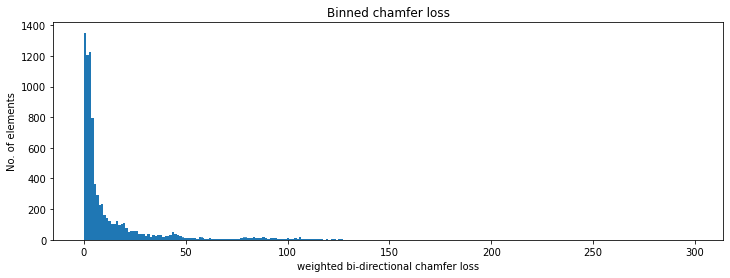

In [49]:
dists = chamfer_evaluate(modified_preds, cloud_list[:limit], id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size, threshold, icp_correction = False)

if inference:
    with open(model_path/('preds_finetuned_' + 'pipe' + '.pkl'), 'wb') as f:
        pickle.dump([modified_preds, id_list, dists], f)

plot_error_graph(dists, "Binned chamfer loss", max_val=300)

In [ ]:
node_dict = get_features_from_params(path)

In [ ]:

# generate points on surface of tee
def generate_tee_cloud(preds):
    # read params
    r1, l1, r2, l2 = abs(preds[0]), preds[1], preds[2], preds[3]
    d1 = get_direction_from_trig(preds, 7)
    d2 = get_direction_from_trig(preds, 13)
    p2 = [preds[4], preds[5], preds[6]]
    p1 = [p2[i] - ((l1*d1[i])/2) for i in range(3)]

    # get new coordinate frame of tee
    old_z = (0., 0., 1.)
    x_axis = vector_normalise(np.cross(d1, old_z))
    y_axis = vector_normalise(np.cross(d1, x_axis))

    # sample points on main tube
    no_of_axis_points = 50    
    no_of_ring_points = 40
    tube1_points = get_cylinder_points(no_of_axis_points, no_of_ring_points, 
                                      r1, l1, p1, d1, x_axis, y_axis)

    # sample points on secondary tube
    x_axis = vector_normalise(np.cross(d2, old_z))
    y_axis = vector_normalise(np.cross(d2, x_axis))   
    tube2_points = get_cylinder_points(no_of_axis_points, no_of_ring_points, 
                                      r2, l2, p2, d2, x_axis, y_axis)

    # remove points from secondary tube in main tube
    tube2_points = np.array(tube2_points)
    p1, p2 = np.array(p1), np.array(p2)
    p2p1 = p2-p1
    p2p1_mag = vector_mag(p2p1)
    tube2_points_ref = []

    for q in tube2_points:
        dist = vector_mag(np.cross((q-p1), (p2p1))) / p2p1_mag
        print(dist, r1)
        if dist > r1:
            print('r', dist)
            tube2_points_ref.append(q.tolist())

    # remove points from main tube in secondary tube
    tube1_points = np.array(tube1_points)
    p3 = np.array(p2 + d2)
    p2p3 = p2-p3
    p2p3_mag = vector_mag(p2p3)
    tube1_points_ref = []

    for q in tube1_points:
        dist = vector_mag(np.cross((q-p3), (p2p3))) / p2p3_mag
        cos_theta = np.dot(q-p2, p2p3)
        if dist > r2 or cos_theta > 0:
            tube1_points_ref.append(q.tolist())

    # make sure not all points are deleted if predictions are very wrong
    thresh = 50
    if len(tube1_points_ref) < thresh and len(tube2_points_ref) < thresh:
        return (tube1_points + tube2_points)
    elif len(tube2_points_ref) < thresh:
        return (tube1_points_ref + tube2_points)
    elif len(tube1_points_ref) < thresh:
        return (tube1_points + tube2_points_ref)
    else:
        return (tube1_points_ref + tube2_points_ref)


In [ ]:
preds = torch.tensor([predictions_list[1]]).cuda()
print(predictions_list[1])
pcd = generate_tee_cloud_tensor(preds)
#tee = generate_tee_cloud(predictions_list[0])
tee = pcd[0].cpu().numpy()
tee = o3d.utility.Vector3dVector(tee)
tee_cloud = o3d.geometry.PointCloud()
tee_cloud.points = tee
o3d.io.write_point_cloud("tee_cl.pcd", tee_cloud)


In [ ]:
original = cloud_list[2]
points= o3d.utility.Vector3dVector(original.transpose(1,0))
tee_cloud.points = points
o3d.io.write_point_cloud("tee_cl_inp.pcd", tee_cloud)

In [ ]:
# undo normalisation opf the bp tee dataset created for inference, only for comparison with the inferred tee results
tee_path = 'tee_fix/tee/test/'
metadata_file = open("tee_fix/tee/metadata.json", 'r')
metadata = json.load(metadata_file)
output_path = 'tee_fix/tee/unnormalised/'

files = os.listdir(tee_path)
new_points = []
for f in tqdm(files):
    cloud_data = metadata[f.split(".")[0]]
    points = np.array(o3d.io.read_point_cloud(tee_path + f).points)
    print("a", points[0])
    print(cloud_data["norm_factor"], cloud_data["mean"])
    points *= cloud_data["norm_factor"]
    print("b", points[0])

    for i, pnt in enumerate(points):
        pnt += cloud_data["mean"]
    print("c", points[10])
    new_points.append(points)
        
new_points = o3d.utility.Vector3dVector(np.concatenate(new_points))
new_cloud = o3d.geometry.PointCloud()
new_cloud.points = new_points
o3d.io.write_point_cloud(output_path+"tee_bp_unnormalised.pcd", new_cloud)

## Mesh deformation

In [ ]:
pr = [0.5,1.0, 0.2, 10., 10., 10., math.sin(0.75), math.cos(0.75), math.sin(0.75), math.cos(0.75), math.sin(0.75), math.cos(0.75)]

pr_tensor = torch.tensor([pr]).cuda()
pcd = generate_flange_cloud_tensor(pr_tensor)
pcd = pcd[0].cpu().numpy()

#pcd = generate_flange_cloud(pr)

print(len(pcd))
new_points = o3d.utility.Vector3dVector(pcd)
new_cloud = o3d.geometry.PointCloud()
new_cloud.points = new_points
o3d.io.write_point_cloud("sample_flange.pcd", new_cloud)

